# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

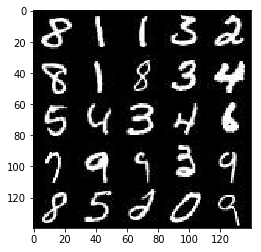

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

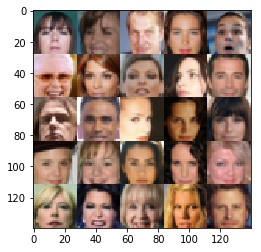

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/osboxes/Development/python/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4 * 4 *256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = is_train != True
    with tf.variable_scope('generator', reuse=reuse):
        
        layer1 = tf.layers.dense(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.nn.dropout(layer1, 0.5)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.nn.dropout(layer2, 0.5)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.nn.dropout(layer3, 0.5)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
    print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2583... Generator Loss: 2.1835
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 1.4490
Epoch 1/2... Discriminator Loss: 0.2328... Generator Loss: 2.7620
Epoch 1/2... Discriminator Loss: 0.1571... Generator Loss: 3.5587
Epoch 1/2... Discriminator Loss: 0.4562... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 2.8316
Epoch 1/2... Discriminator Loss: 0.2622... Generator Loss: 2.9849
Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 3.6370
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 5.4398
Epoch 1/2... Discriminator Loss: 0.3473... Generator Loss: 2.1544


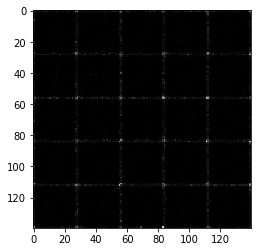

Epoch 1/2... Discriminator Loss: 0.4370... Generator Loss: 2.3848
Epoch 1/2... Discriminator Loss: 0.3271... Generator Loss: 2.7574
Epoch 1/2... Discriminator Loss: 0.3059... Generator Loss: 2.4396
Epoch 1/2... Discriminator Loss: 0.4951... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.7887
Epoch 1/2... Discriminator Loss: 0.3977... Generator Loss: 2.2652
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 1.3018
Epoch 1/2... Discriminator Loss: 0.6886... Generator Loss: 3.8615
Epoch 1/2... Discriminator Loss: 0.6624... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 1.8169


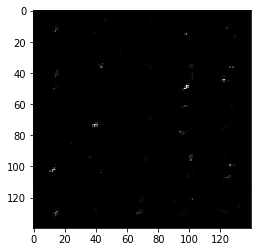

Epoch 1/2... Discriminator Loss: 0.2902... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 5.0024
Epoch 1/2... Discriminator Loss: 0.3098... Generator Loss: 2.1146
Epoch 1/2... Discriminator Loss: 0.3126... Generator Loss: 2.8248
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.2588... Generator Loss: 2.2382
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 2.7306
Epoch 1/2... Discriminator Loss: 1.6616... Generator Loss: 5.6970
Epoch 1/2... Discriminator Loss: 0.2718... Generator Loss: 1.9397
Epoch 1/2... Discriminator Loss: 0.2497... Generator Loss: 2.2812


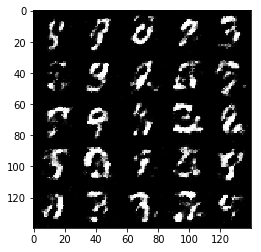

Epoch 1/2... Discriminator Loss: 0.2707... Generator Loss: 2.0066
Epoch 1/2... Discriminator Loss: 0.2870... Generator Loss: 3.3761
Epoch 1/2... Discriminator Loss: 1.6668... Generator Loss: 6.5594
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 2.7945
Epoch 1/2... Discriminator Loss: 0.2824... Generator Loss: 2.2775
Epoch 1/2... Discriminator Loss: 0.2864... Generator Loss: 2.1009
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 5.8376
Epoch 1/2... Discriminator Loss: 0.3998... Generator Loss: 1.6243
Epoch 1/2... Discriminator Loss: 0.2422... Generator Loss: 2.4393
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 1.2326


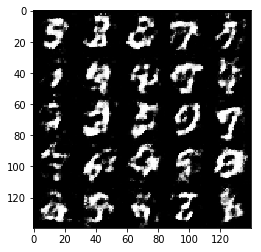

Epoch 1/2... Discriminator Loss: 0.3321... Generator Loss: 1.9041
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 1.9182
Epoch 1/2... Discriminator Loss: 0.2248... Generator Loss: 2.7242
Epoch 1/2... Discriminator Loss: 0.2949... Generator Loss: 1.7196
Epoch 1/2... Discriminator Loss: 0.2480... Generator Loss: 2.8649
Epoch 1/2... Discriminator Loss: 0.2033... Generator Loss: 2.3480
Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 4.2327
Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.9450
Epoch 1/2... Discriminator Loss: 0.2454... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 0.2515... Generator Loss: 2.5972


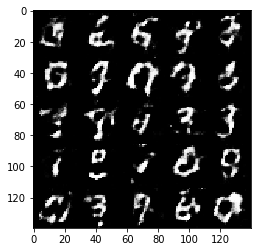

Epoch 1/2... Discriminator Loss: 0.3043... Generator Loss: 1.9955
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 0.2843... Generator Loss: 2.4813
Epoch 1/2... Discriminator Loss: 0.2845... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 0.2351... Generator Loss: 3.1031
Epoch 1/2... Discriminator Loss: 0.1327... Generator Loss: 3.0515
Epoch 1/2... Discriminator Loss: 0.1608... Generator Loss: 2.9198
Epoch 1/2... Discriminator Loss: 0.3034... Generator Loss: 2.1479
Epoch 1/2... Discriminator Loss: 0.2768... Generator Loss: 3.2568
Epoch 1/2... Discriminator Loss: 0.2857... Generator Loss: 2.2234


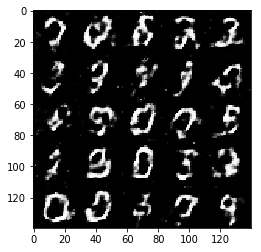

Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 0.2777... Generator Loss: 2.3421
Epoch 1/2... Discriminator Loss: 0.2077... Generator Loss: 2.9343
Epoch 1/2... Discriminator Loss: 0.1874... Generator Loss: 2.9510
Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 1.8383
Epoch 1/2... Discriminator Loss: 1.9457... Generator Loss: 5.8022
Epoch 1/2... Discriminator Loss: 0.6895... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 1.6697
Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 2.2394
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 4.1816


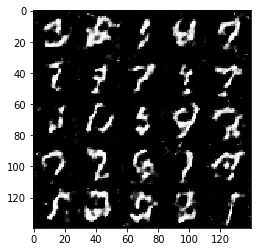

Epoch 1/2... Discriminator Loss: 0.4394... Generator Loss: 3.4454
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 2.2486
Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 2.9777
Epoch 1/2... Discriminator Loss: 0.2894... Generator Loss: 2.3718
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 3.2357
Epoch 1/2... Discriminator Loss: 0.3715... Generator Loss: 2.6555
Epoch 1/2... Discriminator Loss: 0.5049... Generator Loss: 4.6546
Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 1.2550


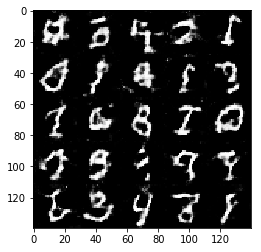

Epoch 1/2... Discriminator Loss: 0.3901... Generator Loss: 1.7703
Epoch 1/2... Discriminator Loss: 0.3280... Generator Loss: 2.6661
Epoch 1/2... Discriminator Loss: 0.3117... Generator Loss: 2.8208
Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 1.8999
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 2.4045
Epoch 1/2... Discriminator Loss: 0.3211... Generator Loss: 1.9979
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 2.2083


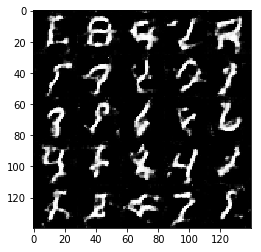

Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 2.3199
Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 3.4272
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 1.5816
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 2.0052
Epoch 2/2... Discriminator Loss: 0.4182... Generator Loss: 1.8343
Epoch 2/2... Discriminator Loss: 0.7061... Generator Loss: 1.2284
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 3.7167
Epoch 2/2... Discriminator Loss: 0.3200... Generator Loss: 2.3411


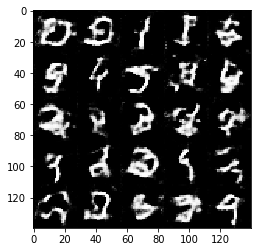

Epoch 2/2... Discriminator Loss: 0.2812... Generator Loss: 2.0724
Epoch 2/2... Discriminator Loss: 0.3398... Generator Loss: 2.2154
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 3.0761
Epoch 2/2... Discriminator Loss: 0.3672... Generator Loss: 3.0611
Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 1.5699
Epoch 2/2... Discriminator Loss: 0.2554... Generator Loss: 2.7338
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 1.8615
Epoch 2/2... Discriminator Loss: 0.2702... Generator Loss: 2.2044


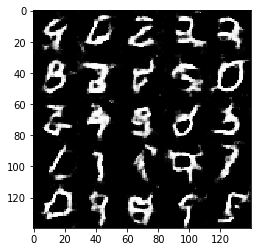

Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.3411
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 1.7540
Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 2.9694
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.4262... Generator Loss: 1.7314
Epoch 2/2... Discriminator Loss: 0.3506... Generator Loss: 1.9746
Epoch 2/2... Discriminator Loss: 0.3230... Generator Loss: 1.7439
Epoch 2/2... Discriminator Loss: 0.2952... Generator Loss: 2.5019
Epoch 2/2... Discriminator Loss: 0.4762... Generator Loss: 3.5652


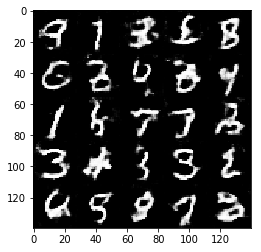

Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 1.5302
Epoch 2/2... Discriminator Loss: 0.3523... Generator Loss: 2.3595
Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 1.8085
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.8124
Epoch 2/2... Discriminator Loss: 0.3171... Generator Loss: 2.1095
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 2.3323
Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 1.6619
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 4.3875
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 2.4839


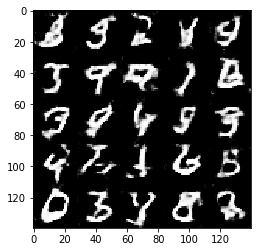

Epoch 2/2... Discriminator Loss: 0.2979... Generator Loss: 2.4363
Epoch 2/2... Discriminator Loss: 0.3511... Generator Loss: 1.6717
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 3.2105
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 2.6095
Epoch 2/2... Discriminator Loss: 0.3241... Generator Loss: 2.6476
Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 1.9286
Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 1.4018
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 3.5014
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 1.8855
Epoch 2/2... Discriminator Loss: 0.5036... Generator Loss: 1.4640


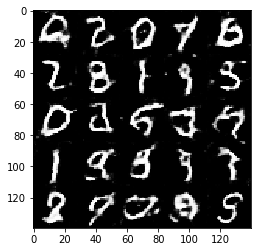

Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.3514
Epoch 2/2... Discriminator Loss: 0.3144... Generator Loss: 2.5195
Epoch 2/2... Discriminator Loss: 0.3051... Generator Loss: 1.5018
Epoch 2/2... Discriminator Loss: 0.3134... Generator Loss: 1.8278
Epoch 2/2... Discriminator Loss: 0.3510... Generator Loss: 3.1297
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 2.4260
Epoch 2/2... Discriminator Loss: 0.4453... Generator Loss: 2.0833
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 3.5552
Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 1.6074


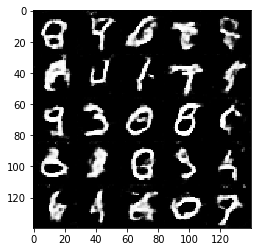

Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 1.8340
Epoch 2/2... Discriminator Loss: 0.3155... Generator Loss: 3.0015
Epoch 2/2... Discriminator Loss: 0.3305... Generator Loss: 2.7849
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.4159
Epoch 2/2... Discriminator Loss: 0.2908... Generator Loss: 2.1214
Epoch 2/2... Discriminator Loss: 0.3728... Generator Loss: 1.8616
Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 1.3539
Epoch 2/2... Discriminator Loss: 0.5437... Generator Loss: 3.2888
Epoch 2/2... Discriminator Loss: 0.3077... Generator Loss: 3.2313


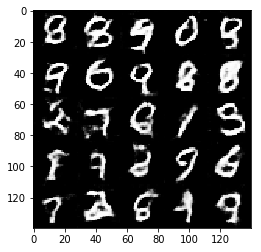

Epoch 2/2... Discriminator Loss: 0.3512... Generator Loss: 1.6250
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.4987
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 0.3705... Generator Loss: 2.5216
Epoch 2/2... Discriminator Loss: 0.2794... Generator Loss: 2.0417
Epoch 2/2... Discriminator Loss: 0.2657... Generator Loss: 2.8108
Epoch 2/2... Discriminator Loss: 0.3546... Generator Loss: 1.5850
Epoch 2/2... Discriminator Loss: 0.2272... Generator Loss: 2.7095
Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 3.1004
Epoch 2/2... Discriminator Loss: 0.3071... Generator Loss: 2.3234


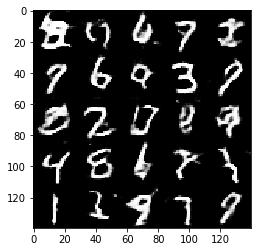

Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 2.2426
Epoch 2/2... Discriminator Loss: 0.2922... Generator Loss: 2.9698
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 5.4698
Epoch 2/2... Discriminator Loss: 0.3667... Generator Loss: 2.6635
Epoch 2/2... Discriminator Loss: 0.2638... Generator Loss: 2.2889
Epoch 2/2... Discriminator Loss: 0.3121... Generator Loss: 2.2806
Epoch 2/2... Discriminator Loss: 0.3218... Generator Loss: 2.4918
Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 3.0179
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.9779
Epoch 2/2... Discriminator Loss: 0.2806... Generator Loss: 2.4607


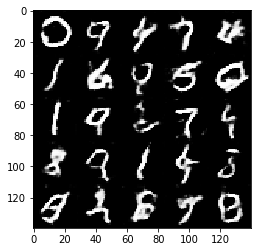

Epoch 2/2... Discriminator Loss: 0.3409... Generator Loss: 1.8363
Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 2.5329
Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 2.3142
Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 1.5849
Epoch 2/2... Discriminator Loss: 0.2588... Generator Loss: 2.2402
Epoch 2/2... Discriminator Loss: 0.2261... Generator Loss: 2.4068
Epoch 2/2... Discriminator Loss: 0.4142... Generator Loss: 1.8567


In [36]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1504... Generator Loss: 2.8661
Epoch 1/1... Discriminator Loss: 0.0535... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 3.4657
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 4.2272
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 4.2604
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.5639
Epoch 1/1... Discriminator Loss: 0.0252... Generator Loss: 5.4361
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 4.3273
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 4.2206
Epoch 1/1... Discriminator Loss: 2.2284... Generator Loss: 0.1421


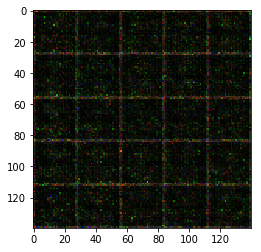

Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 3.8162
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.9152
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 4.4151
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 4.6450
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.1548
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 4.2417
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 3.2340
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 3.8203
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 4.4149
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 4.0662


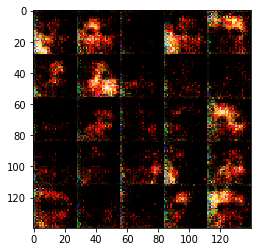

Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 2.4339
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 4.9580
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 4.4041
Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 4.6275
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 4.4696
Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 4.7830
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 4.7617
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 4.4334
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 3.7807


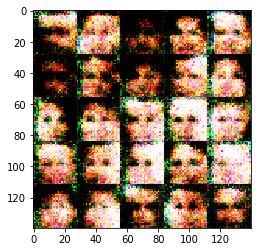

Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.6101
Epoch 1/1... Discriminator Loss: 0.0692... Generator Loss: 3.6967
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 3.6477
Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 6.9828... Generator Loss: 14.8235
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 3.0560
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 3.5664
Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.7454
Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 3.6629
Epoch 1/1... Discriminator Loss: 0.0535... Generator Loss: 3.8769


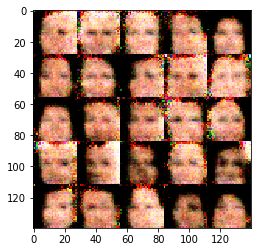

Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 4.1048
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 4.5753
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 4.6630
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 3.9995
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.6991
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 3.7438
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 4.5237
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 3.2893
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 2.8471
Epoch 1/1... Discriminator Loss: 0.1551... Generator Loss: 2.5935


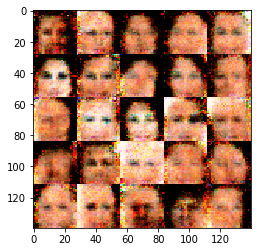

Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 2.6731
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 6.5279
Epoch 1/1... Discriminator Loss: 0.1631... Generator Loss: 2.5393
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 3.8961
Epoch 1/1... Discriminator Loss: 0.1553... Generator Loss: 3.7866
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 3.4768
Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 4.3836
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 2.4742
Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 2.9534


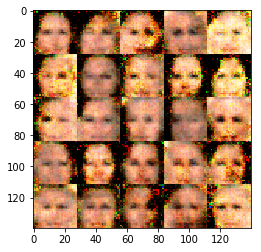

Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 3.4603
Epoch 1/1... Discriminator Loss: 0.0771... Generator Loss: 3.6192
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.2593
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.8732
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.2241
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 3.6764
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.1555... Generator Loss: 2.9435
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 3.3004
Epoch 1/1... Discriminator Loss: 0.1163... Generator Loss: 3.0085


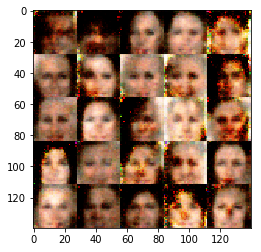

Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 3.1450
Epoch 1/1... Discriminator Loss: 0.0886... Generator Loss: 3.2934
Epoch 1/1... Discriminator Loss: 0.1140... Generator Loss: 2.7210
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 1.6740
Epoch 1/1... Discriminator Loss: 0.1355... Generator Loss: 3.1338
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 3.0486
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 4.6116
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 2.9992
Epoch 1/1... Discriminator Loss: 3.8557... Generator Loss: 8.8637
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 3.0065


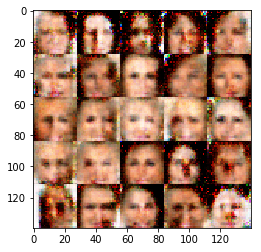

Epoch 1/1... Discriminator Loss: 0.1738... Generator Loss: 2.7794
Epoch 1/1... Discriminator Loss: 0.1020... Generator Loss: 3.4254
Epoch 1/1... Discriminator Loss: 0.1693... Generator Loss: 2.6882
Epoch 1/1... Discriminator Loss: 0.1113... Generator Loss: 3.2372
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.3854
Epoch 1/1... Discriminator Loss: 0.0567... Generator Loss: 4.0513
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 3.0295
Epoch 1/1... Discriminator Loss: 0.1122... Generator Loss: 3.5697


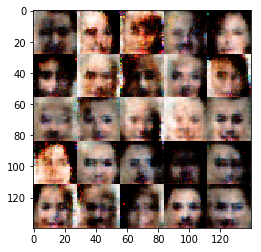

Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 2.3472
Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 2.8285
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 2.1472
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 2.2680
Epoch 1/1... Discriminator Loss: 0.2224... Generator Loss: 2.6276
Epoch 1/1... Discriminator Loss: 0.2076... Generator Loss: 3.4538
Epoch 1/1... Discriminator Loss: 0.1496... Generator Loss: 2.5179


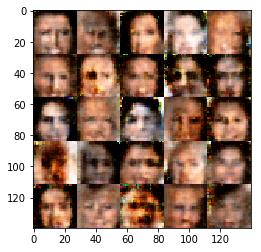

Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 2.2787
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.3244
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 2.5230
Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 2.5787
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 3.5829
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 2.6767
Epoch 1/1... Discriminator Loss: 0.2554... Generator Loss: 2.7386
Epoch 1/1... Discriminator Loss: 3.0510... Generator Loss: 0.0800
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 1.8757


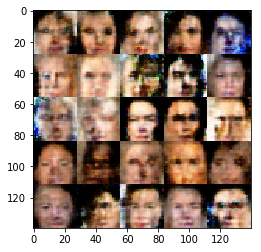

Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 1.7838
Epoch 1/1... Discriminator Loss: 0.2923... Generator Loss: 2.3843
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 4.4956
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 3.5946
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.2891... Generator Loss: 2.0622
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 1.9917
Epoch 1/1... Discriminator Loss: 0.3051... Generator Loss: 2.5390
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.5885


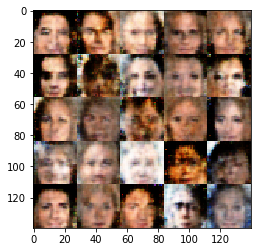

Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 2.1916
Epoch 1/1... Discriminator Loss: 0.2310... Generator Loss: 2.8565
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 2.4667
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 3.1859
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 2.8384
Epoch 1/1... Discriminator Loss: 1.7472... Generator Loss: 5.5475
Epoch 1/1... Discriminator Loss: 0.2806... Generator Loss: 2.2453
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 2.2794


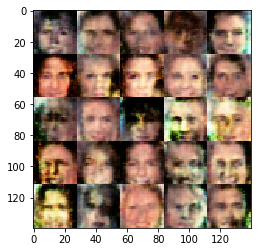

Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 2.5999
Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.0763
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 3.1781
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.4772
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.3160
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.2638
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 1.5441


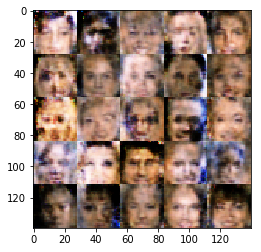

Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 1.4212
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 2.1684
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.9223
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.4522


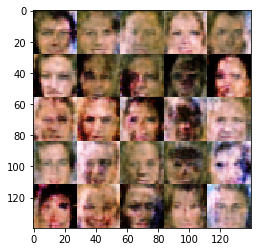

Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 3.3643
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.8425
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 0.4435... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.2899
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 0.7623


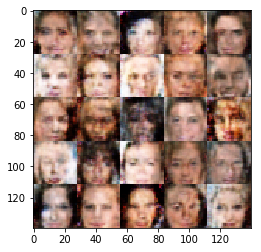

Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 1.6679
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 2.2280
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 2.0307


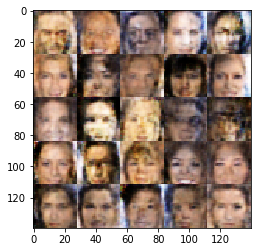

Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 1.9336
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 4.3479
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 2.1242
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.0718
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.4661
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.9488
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 2.1964


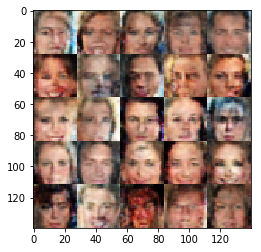

Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 2.4622
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.9643
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 2.9429
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.8828


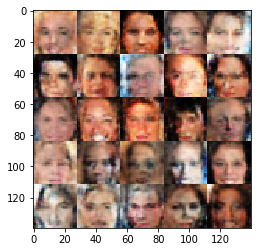

Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 0.3788... Generator Loss: 1.7517
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.9255
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 1.6413
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 3.9496
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 1.9595
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 1.7535


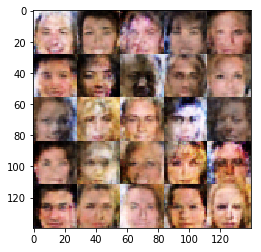

Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 2.3586
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 2.5841
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 1.3065


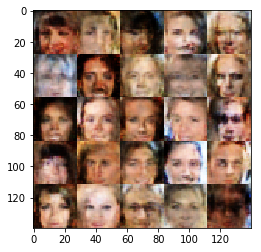

Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 2.2960
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.1638
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 1.4982
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 1.8671
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 2.5785


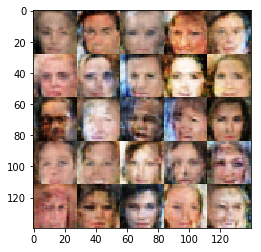

Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 1.6609
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.4489
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 2.0901
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 1.3662


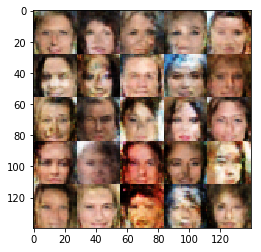

Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 2.1279
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 1.6964
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 1.5394
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 3.2634
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.2034


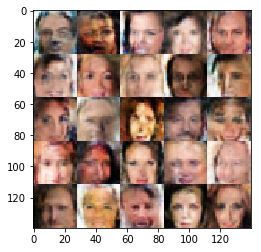

Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 2.8533
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 2.9220
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 2.9459
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.0442
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 1.7554


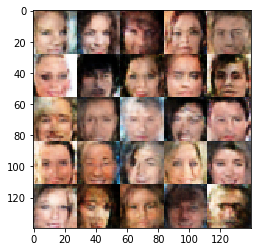

Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.8857
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.7792
Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.7276
Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.9411
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 1.6635
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 0.9926


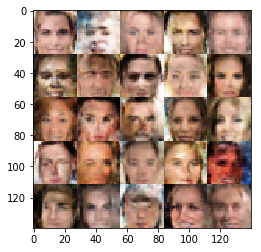

Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 1.8338
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 1.8535
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 1.7296
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 2.0224


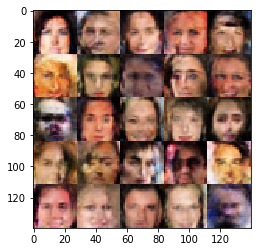

Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 1.8499
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.2663
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.3083
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 2.4592
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.2720
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 1.8550... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.0339


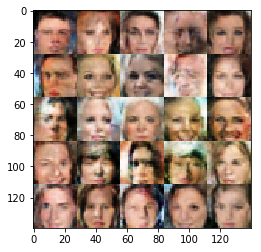

Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 2.6019
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.9885
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 1.7755
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.4069
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 1.3686
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 1.7648


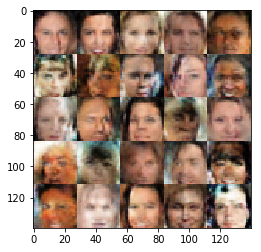

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 3.9821
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 1.0461
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 1.9813
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 3.1219
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 1.8830


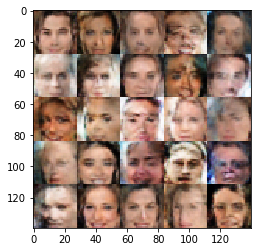

Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.5488
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.5397
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.4256
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.8571
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 1.6675


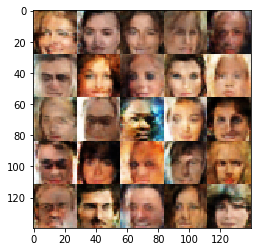

Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 1.4354
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 2.7942
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.1906


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.